In [4]:
import numpy as np
import pandas as pd 
from pandas import read_excel
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns


from dateutil.relativedelta import relativedelta 
from scipy.optimize import minimize              

import statsmodels.formula.api as smf          
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    
from tqdm import tqdm_notebook

import math
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [5]:
tr = pd.read_csv("../train.min.csv")
te = pd.read_csv("../test.min.csv")

In [6]:
tr.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,browser,operatingSystem,isMobile,...,medium,keyword,isTrueDirect,referralPath,adContent,adwordsClickInfo.page,adwordsClickInfo.slot,adwordsClickInfo.gclId,adwordsClickInfo.adNetworkType,adwordsClickInfo.isVideoAd
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1.472830e+09,1,1.472830e+09,Chrome,Windows,False,...,organic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1.472880e+09,1,1.472880e+09,Firefox,Macintosh,False,...,organic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1.472865e+09,1,1.472865e+09,Chrome,Windows,False,...,organic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,1.472881e+09,1,1.472881e+09,UC Browser,Linux,False,...,organic,google + online,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,1.472823e+09,2,1.472823e+09,Chrome,Android,True,...,organic,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
tstr = tr[['date','transactionRevenue']]

In [12]:
from datetime import datetime
tstr[['date']] = tstr[['date']].applymap(str).applymap(lambda s: "{}-{}-{}".format(s[0:4], s[4:6],s[6:]))
tstr = tstr.fillna(0)

In [9]:
tstr.head()

,date,transactionRevenue
0,2016-09-02,NaN
1,2016-09-02,NaN
2,2016-09-02,NaN
3,2016-09-02,NaN
4,2016-09-02,NaN


In [13]:
tstr = tstr.fillna(0)
tstr.head()

,date,transactionRevenue
0,2016-09-02,0.0
1,2016-09-02,0.0
2,2016-09-02,0.0
3,2016-09-02,0.0
4,2016-09-02,0.0


In [44]:
tstr['Revenue'] = (np.exp(tstr['transactionRevenue'])-1)/1000000

In [45]:
tstr['date'] = pd.to_datetime(tstr['date'], format = '%Y-%m-%d')

### Calculate daily mean

In [107]:
tstr_d = tstr.groupby(['date'], as_index=False).mean()
tstr_d.head()

,date,transactionRevenue,Revenue
0,2016-08-01,0.354300,3.574553
1,2016-08-02,0.141498,0.636070
2,2016-08-03,0.000000,0.000000
3,2016-08-04,0.092381,0.374214
4,2016-08-05,0.273975,2.070415


#### Original data was already log transformed transaction revenue = (log(transaction revenue * 1000000 + 1)), so I do not need to perform any log transformation during building the ARIMA models

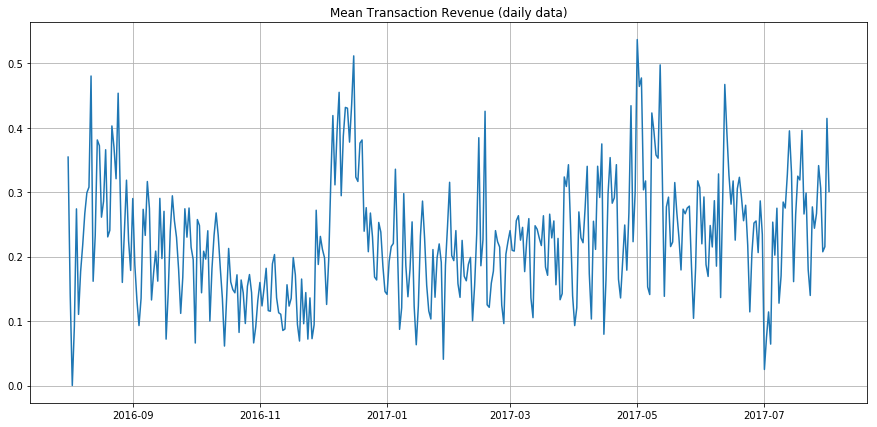

In [108]:
plt.figure(figsize=(15, 7))
plt.plot(tstr_d.date,tstr_d.transactionRevenue)
plt.title('Mean Transaction Revenue (daily data)')
plt.grid(True)
plt.show()


## Trend Analysis

In [48]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [49]:
def root_mean_squared_error(y_true, y_pred):
    return math.sqrt(np.mean((y_true - y_pred) **2)) * 100

In [109]:
Revenue = tstr_d.copy()
Revenue = Revenue.set_index('date')

In [110]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(Revenue['transactionRevenue'], 7) #Moving Average of a week

0.2931593854744959

In [111]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

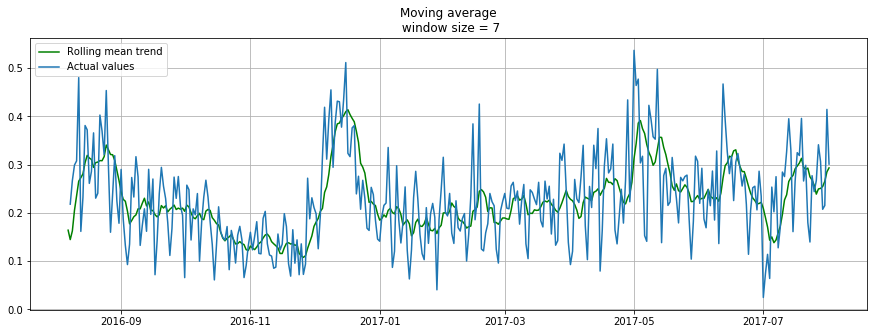

In [112]:
plotMovingAverage(Revenue['transactionRevenue'], 7) # Weekly Moving Average

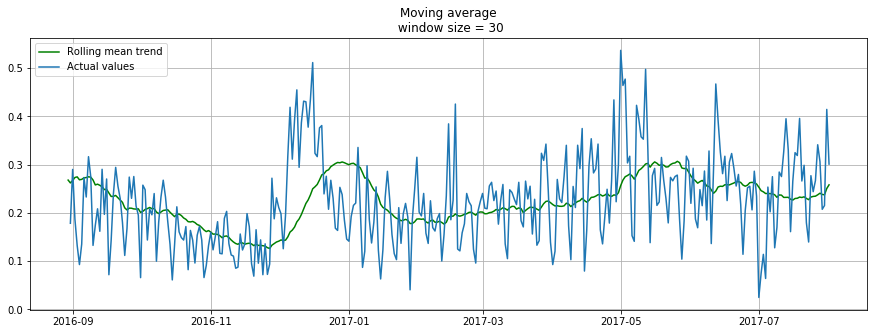

In [113]:
plotMovingAverage(Revenue['transactionRevenue'], 30) #Monthly Moving Average

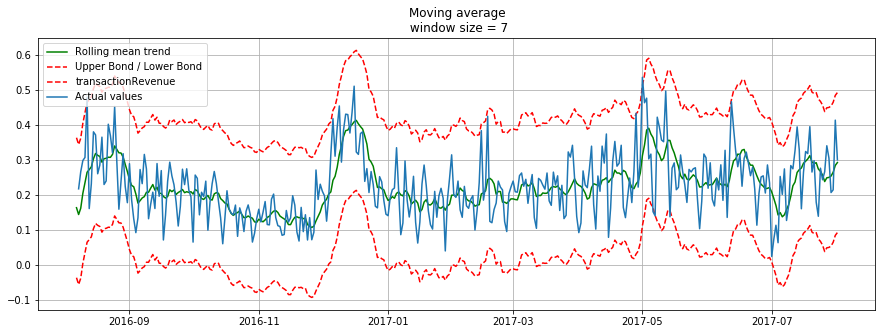

In [114]:
plotMovingAverage(Revenue['transactionRevenue'], 7, plot_intervals=True)

In [115]:
r = Revenue[['transactionRevenue']]

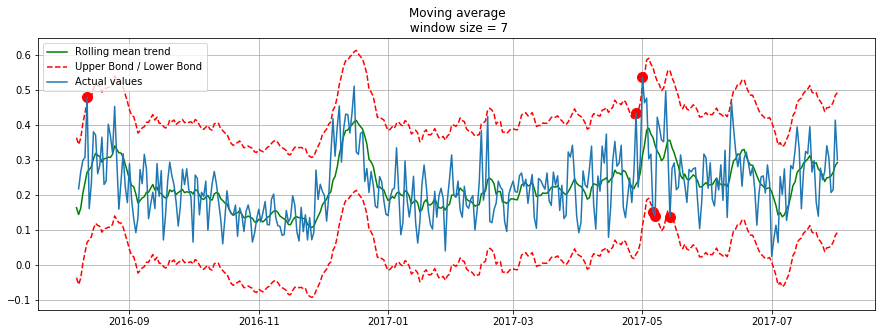

In [116]:
plotMovingAverage(r, 7, plot_intervals=True, plot_anomalies=True)

### Exponential Smoothing

In [117]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [118]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

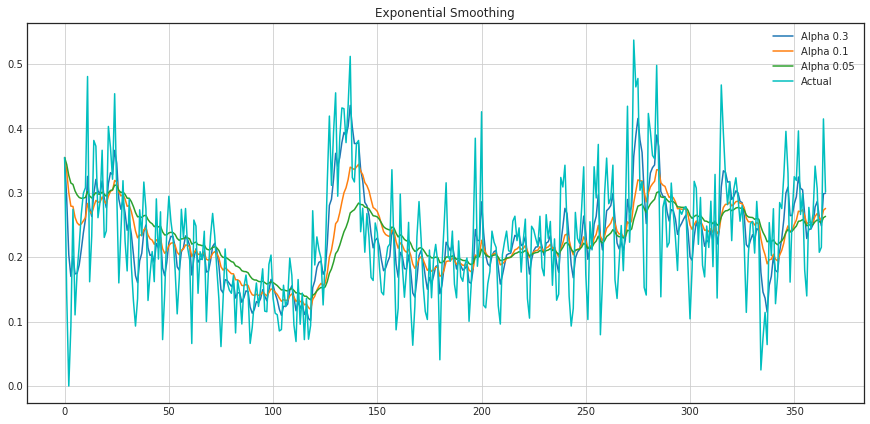

In [119]:
plotExponentialSmoothing(Revenue['transactionRevenue'], [0.3, 0.1, 0.05])

### Double exponential smoothing

In [120]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

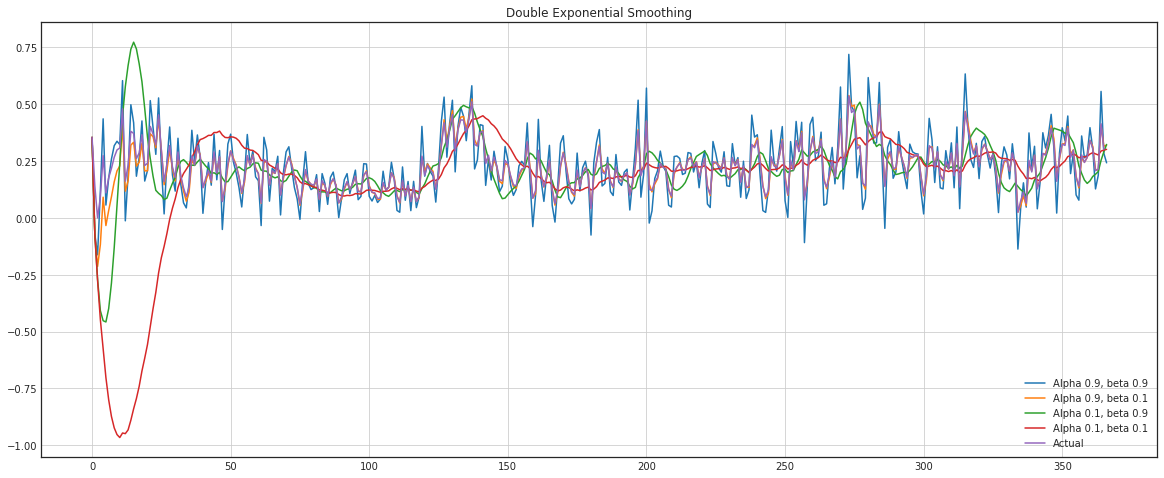

In [121]:
plotDoubleExponentialSmoothing(Revenue.transactionRevenue, alphas=[0.9, 0.1], betas=[0.9, 0.1])

### Holt-Winters

In [122]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [124]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=7):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

#### Train model using automatic triple exponential method (Holt-Winters)

In [125]:
%%time
data = Revenue.transactionRevenue[:-60] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, root_mean_squared_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 90 days
model = HoltWinters(data, slen = 7, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 120, scaling_factor = 3)
model.triple_exponential_smoothing()

0.4364463370941392 0.020444060064036373 0.1515457842751512
CPU times: user 2.21 s, sys: 12.7 ms, total: 2.22 s
Wall time: 2.22 s


#### Render plot

In [126]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    #error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    error = root_mean_squared_error(series.values, model.result[:len(series)])
    #error = mean_squared_log_error(series.values, model.result[:len(series)])
    plt.title("Root Mean Squared Prediction Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-60, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

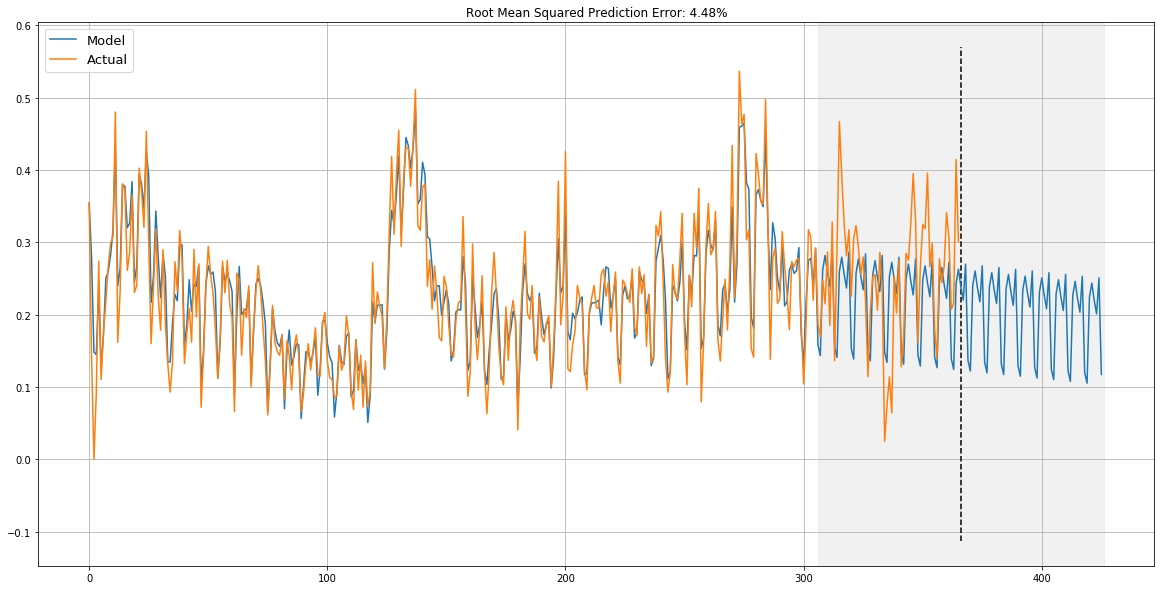

In [127]:
plotHoltWinters(Revenue.transactionRevenue)

It looks ok. Captures the main trends. 

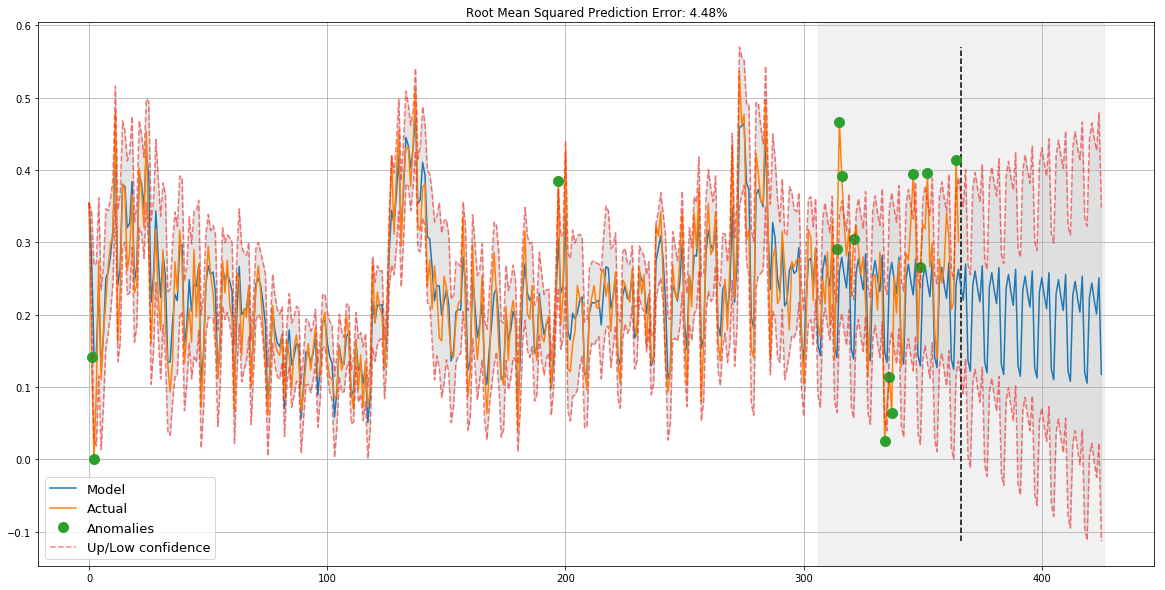

In [129]:
plotHoltWinters(Revenue.transactionRevenue, plot_intervals=True, plot_anomalies=True)

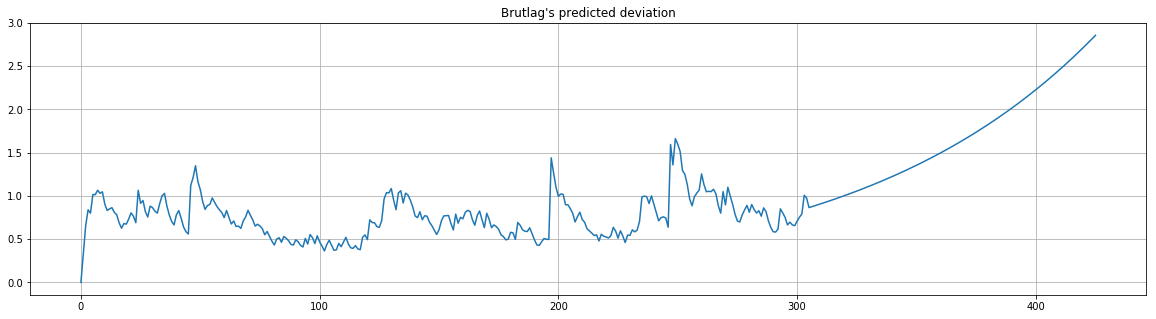

In [69]:
plt.figure(figsize=(20, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

### SARIMA
- Getting rid of non-stationary

In [86]:
r = Revenue[['transactionRevenue']]

In [73]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

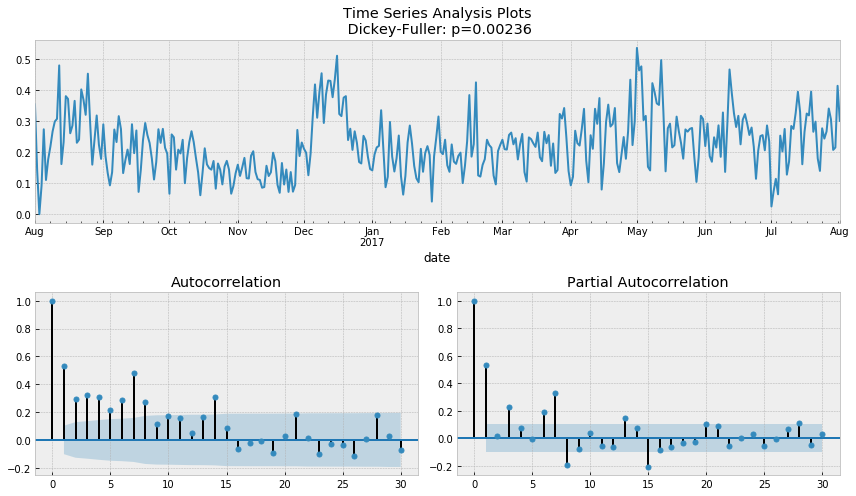

In [74]:
tsplot(Revenue.transactionRevenue, lags=30)

Surprisingly, the initial series are stationary; the Dickey-Fuller test rejected the null hypothesis that a unit root is present.

Seasonality is somehow significant. Try a week shift.

Take seasonal difference of 7 days.

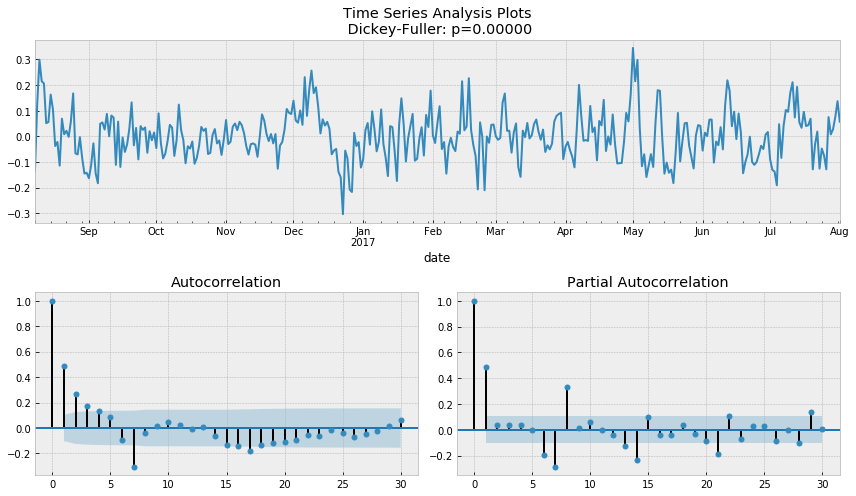

In [75]:
Revenue_diff = Revenue.transactionRevenue - Revenue.transactionRevenue.shift(7)
tsplot(Revenue_diff[7:], lags=30)

Take the 1st difference to check the performance.

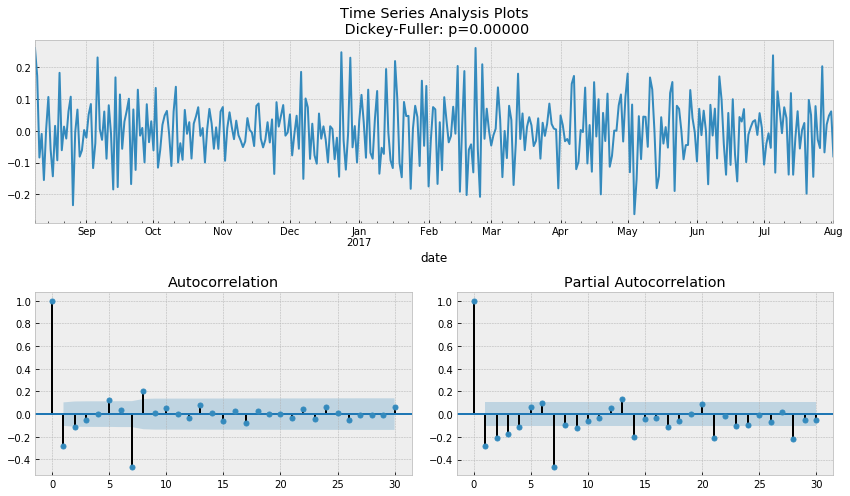

In [76]:
Revenue_diff_1 = Revenue_diff - Revenue_diff.shift(1)
tsplot(Revenue_diff_1[7+1:], lags=30) #Doesn't seem to improve

- p  is most probably 0 since most others are not significant.
- d equals 0 because we had first differences that not perform well
- q should be 0 as well as seen on the ACF
- P might be 4, since 7-th, 14-th, 21th and 28-th lags are somewhat significant on the PACF
- D equals 1 because we performed seasonal differentiation
- Q is probably 1. The 7-th lag on ACF is significant while the others are not.

- AR(p)  - autoregression model i.e. regression of the time series onto itself. The basic assumption is that the current series values depend on its previous values with some lag (or several lags). The maximum lag in the model is referred to as p. To determine the initial p, you need to look at the PACF plot and find the biggest significant lag after which most other lags become insignificant.




- MA(q) - moving average model. Without going into too much detail, this models the error of the time series, again with the assumption that the current error depends on the previous with some lag, which is referred to as q. The initial value can be found on the ACF plot with the same logic as before.


- I(d)  - order of integration. This is simply the number of nonseasonal differences needed to make the series stationary. 


- S(s) - this is responsible for seasonality and equals the season period length of the series


- P - order of autoregression for the seasonal component of the model, which can be derived from PACF. But you need to look at the number of significant lags, which are the multiples of the season period length. 


- Q - similar logic using the ACF plot instead.


- D - order of seasonal integration. This can be equal to 1 or 0, depending on whether seasonal differeces were applied or not.


In [77]:
# setting initial values and some bounds for them
ps = range(0, 2)
d=0
qs = range(0, 2)
Ps = range(0, 5)
D=1 
Qs = range(0, 2)
s = 7 # season length is 7 days

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

40

In [78]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(Revenue.Revenue, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[3], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [79]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)


CPU times: user 8.81 s, sys: 701 ms, total: 9.51 s
Wall time: 4.85 s


In [80]:
result_table.head(10) #interestingly  P = 0, 1, 2, 3,4 has the same AIC

,parameters,aic
0,"(1, 1, 4, 1)",1126.913337
1,"(1, 1, 3, 1)",1126.913337
2,"(1, 1, 2, 1)",1126.913337
3,"(1, 1, 1, 1)",1126.913337
4,"(1, 1, 0, 1)",1126.913337
5,"(1, 0, 4, 1)",1134.959928
6,"(1, 0, 3, 1)",1134.959928
7,"(1, 0, 2, 1)",1134.959928
8,"(1, 0, 1, 1)",1134.959928
9,"(1, 0, 0, 1)",1134.959928


In [82]:
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(Revenue.transactionRevenue, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                transactionRevenue   No. Observations:                  366
Model:             SARIMAX(1, 0, 1)x(4, 1, 1, 7)   Log Likelihood                 470.408
Date:                           Mon, 22 Jul 2019   AIC                           -924.817
Time:                                   10:08:39   BIC                           -893.750
Sample:                               08-01-2016   HQIC                          -912.463
                                    - 08-01-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8537      0.049     17.468      0.000       0.758       0.949
ma.L1         -0.4125      0.082     -5.047

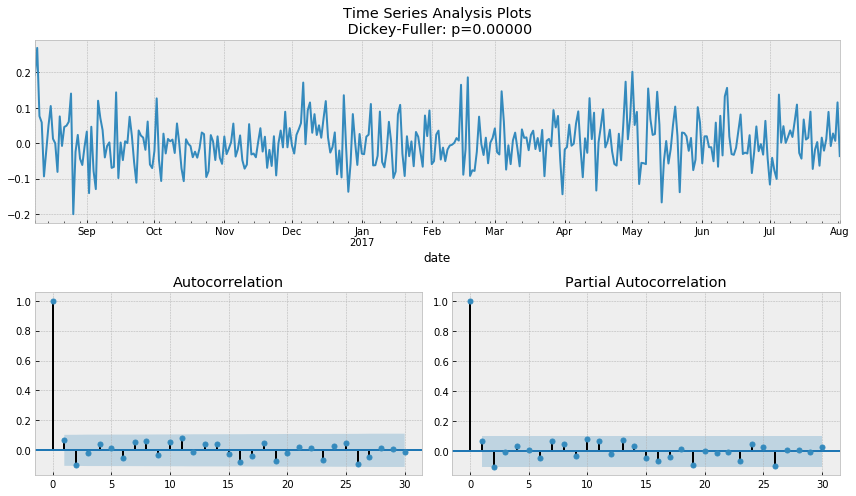

In [83]:
tsplot(best_model.resid[7+1:], lags=30) #Good Good

It is clear that the residuals are stationary, and there are no apparent autocorrelations. 

In [84]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = root_mean_squared_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Root Mean Squared Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

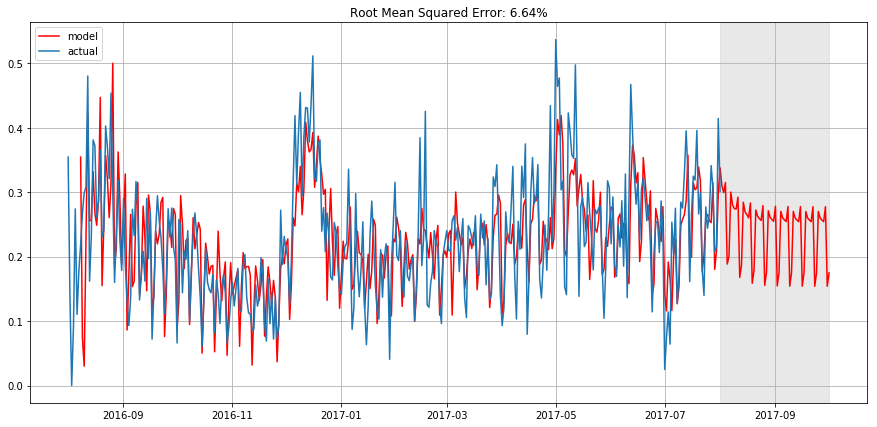

In [87]:
plotSARIMA(r, best_model, 60) # Two Month

#### Since the 4 lags are not significant, I can try without P

In [89]:
p, q, P, Q = result_table.parameters[4]

best_model=sm.tsa.statespace.SARIMAX(Revenue.transactionRevenue, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                transactionRevenue   No. Observations:                  366
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 7)   Log Likelihood                 469.512
Date:                           Mon, 22 Jul 2019   AIC                           -931.024
Time:                                   10:10:34   BIC                           -915.491
Sample:                               08-01-2016   HQIC                          -924.847
                                    - 08-01-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8742      0.039     22.586      0.000       0.798       0.950
ma.L1         -0.4474      0.068     -6.547

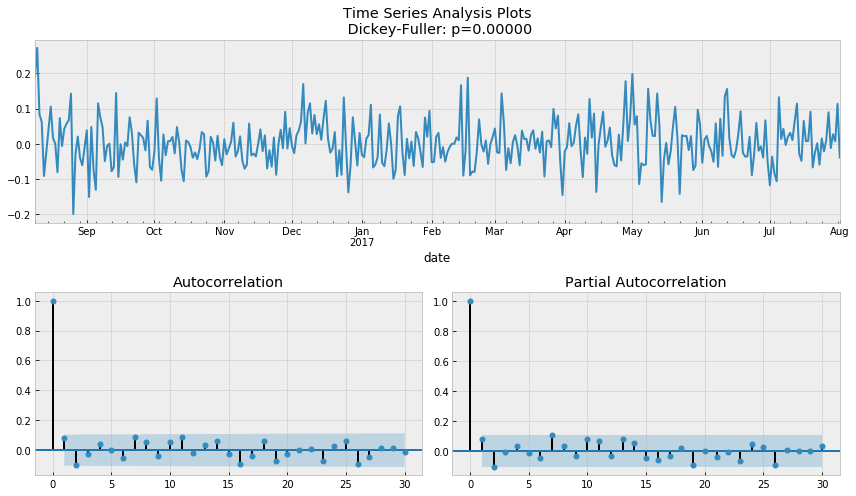

In [90]:
tsplot(best_model.resid[7+1:], lags=30) #No autocorrelation

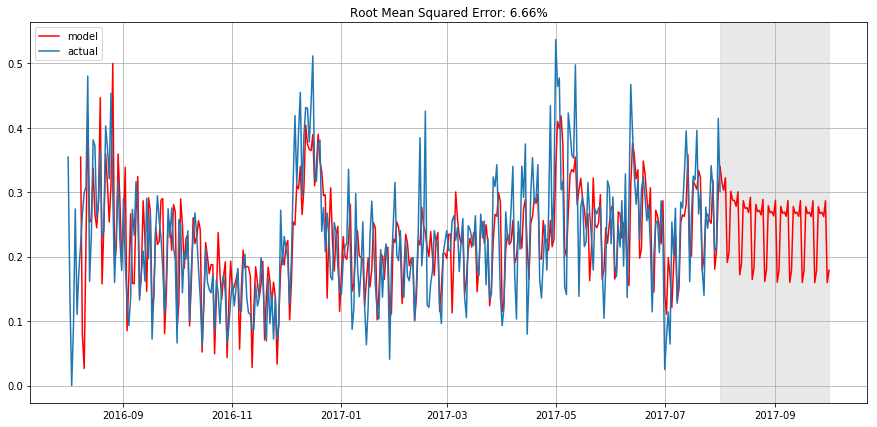

In [91]:
plotSARIMA(r, best_model, 60) # Two Month, result similar